In [ ]:
!nvidia-smi

Fri May 21 19:11:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

* In this note book we are going to build a Convolutional Neural Network (CNN) that classifies the cats and dogs with `~90%` accuracy. To build this model we used the cats and dogs dataset with `25K` samples that can be downloaded from [here](https://www.kaggle.com/c/dogs-vs-cats/overview).

![alt text](https://d2h0cx97tjks2p.cloudfront.net/blogs/wp-content/uploads/sites/2/2020/05/Cats-Dogs-Classification-deep-learning.gif "Cats vs Dogs Classification at a glance")

To do this project we first import essential libraries such as `tensorflow` , `keras` , `sklearn` , etc. and we do general overview on this dataset. In further steps we build, evaluate and deploy the model.



### Importing Essential Libraries and General Overview


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix
from keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import math
from imutils import paths
import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image
import pickle
import random

plt.style.use("ggplot")

Lets load the pickle files that we created in `creating-data.py`. We have to set the model with `rb` which means `read binary.`

In [ ]:
pickle_in = open("X.pickle" , "rb")
X = pickle.load(pickle_in)
pickle_in = open("y.pickle" , "rb")
y = pickle.load(pickle_in)

And then we plot one of the samples of the dataset to see what the images looks like.

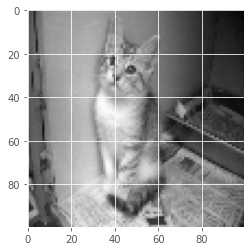

In [ ]:
img_array = np.array(X[12000]).reshape(100 , 100).astype("float32")
plt.imshow(img_array , cmap = "gray")
plt.grid(False)

In [ ]:
y

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

* As we can see from the above array which represents `labels`; the labels are not shuffled which is not good for our model performance. For example if the first `12.5K` samples are cat and the other `12.5K` are dog and when we split the dataset into `training set`(80% of the dataset) and `testing set`(20% of the dataset) most of the samples of training set are cat and **all** of the testing set samples are dog. So when we are training our CNN on training set the `weights` of cat samples are way larger that the `weights` of dog samples, Which will damage the model performance and the model most of the times predicts `cat`. So it is better to shuffle the data.  

In [ ]:
def plotBarchart(array , figsize = (7 , 7)):
  labels_series = pd.Series(y)
  ds = labels_series.value_counts().reset_index()      
  ds.columns = ["Name" , "Count"]
  ds["Name"] = ds["Name"].astype("object")
  
  x_axis = ["Cat" , "Dog"]
  fig , ax = plt.subplots(figsize = figsize)
  ax = sns.barplot(x = "Name" , y = "Count" , data = ds)
  ax.set_xticklabels(x_axis)
  plt.grid(False)

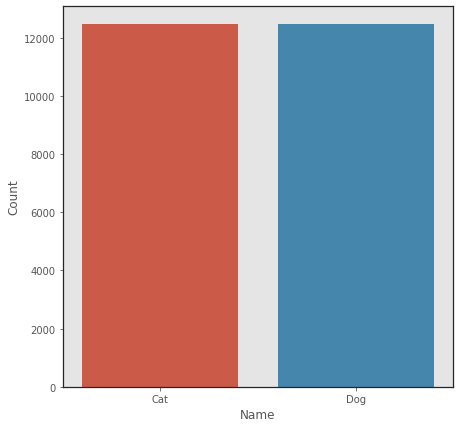

In [ ]:
plotBarchart(y)

* As we can see from the above bar chart, both `cat` and `dog` labels have the same count so we ensured that our dataset is completely `balanced`.

In [ ]:
print("X shape : " , X.shape)
print("y shape : " , y.shape)

X shape :  (24919, 100, 100, 1)
y shape :  (24919,)


In [ ]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = .25 , random_state = 1 , stratify = y , shuffle = True)

* In the next step we splitted our dataset into training set(75% of the data) and test set(the other 25% of the data) with `stratification` mode(`stratify = y`)  which means each of the test set and training set contains the same propotion of class labels as the input dataset.
* To shuffle our dataset, we set `shuffle = True`. 

In [ ]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = lb.fit_transform(y_test)
y_test = to_categorical(y_test)

* To avoid `Data Leakage` we did `One Hot Encoding` on `y_train` and `y_test` seperately.

In [ ]:
y_test[0:5]

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [ ]:
y_train[0:5]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [ ]:
print("X_train shape : " , X_train.shape)
print("y_train shape : " , y_train.shape)
print("X_test shape : " , X_test.shape)
print("y_test shape : " , y_test.shape)

X_train shape :  (18689, 100, 100, 1)
y_train shape :  (18689, 2)
X_test shape :  (6230, 100, 100, 1)
y_test shape :  (6230, 2)


### Data Augmentation and Model Building

One of the ways to avoid model overfitting and neural network regularization is `Data Augmentation` which with this `generator` we are able to increase the generalizability of the model. To do this replace the training data with randomly transfomed images.The whole process of image augmentation is shown below:

![alt text](https://pyimagesearch.com/wp-content/uploads/2019/07/keras_data_augmentation_in_place.png "Image Augmentation Procedure")


[(Image Source)](https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/)

With this data augmetation we can ensure that our neural network sees new images that has never seen before in each epoch. So with this technique we regularize the model, **sacrificing the training accuracy to improve the validation performance**. It is worth mentioning that transformed and augmented images will be discarded after the training process.

In [ ]:
train_datagen = ImageDataGenerator(rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = "nearest"
                                  )

# test_datagen = ImageDataGenerator(rescale = 1.0 / 255.0)

![alt text](https://data-flair.training/blogs/wp-content/uploads/sites/2/2020/05/Cats-vs-Dogs-Classification-deep-learning-project-1200x675.jpg "CNN Architecture")

Credit : [DataFlair](https://data-flair.training)


\
* **Input Layer**: It represent input image data. It will reshape image into single diminsion array. E.g. our image is `100x100x1 = 10000`, it will convert to `(10000,1)` array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layer reduce the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer.

In [ ]:
i = Input(shape = X_train[0].shape)

x = Conv2D(32 , (3 , 3) ,  activation = "relu")(i)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2 , 2))(x)

x = Conv2D(64 , (3 , 3) , activation = "relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2 , 2))(x)

x = Conv2D(128 , (3 , 3) , activation = "relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2 , 2))(x)

x = Conv2D(128 , (3 , 3) , activation = "relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2 , 2))(x)

x = Dropout(rate = 0.5)(x)
x = Flatten()(x)

x = Dense(512 , activation = "relu")(x)
x = Dense(2 , activation = "softmax")(x)
model = Model(i , x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 98, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 47, 47, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0     

* In the next step we are going to define some bunch of learning rate schedules such as `stepwise` , `linear` and `polynomial learning rate schedule`. This learning rate schedules could help the optimizer to reach the minimum loss by decreasing the learning rate after some periods. For example, in `stepwise` schedule we decrease the learning rate with a predefined `factor` after `n` epochs. we can fully customize the `factor` and `n` by ourselves.

* We have to careful that define a appropriate `initial learning rate` and `learning rate schedule`. This is because if we define a large learning rate, maybe our optimizer never reaches the minimimum loss or close to it. This means that the optimizer leads to a divergent behaviour. And if we define a small learning rate, the optimization process will be very slow and reaching the minimum loss takes a long time.

![alt text](https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/images/lr1.png)

Credit : [deeplearningwizard](https://www.deeplearningwizard.com)


In [ ]:
class learning_rate_schedule():
  def plot(self, epochs, title="Learning Rate Schedule"):
    lrs = [self(i) for i in epochs]
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(epochs, lrs)
    plt.title(title)
    plt.xlabel("Epoch #")
    plt.ylabel("Learning Rate")
    plt.show()

class step_decay(learning_rate_schedule):
  def __init__(self, initAlpha = 0.001 , factor = 0.25 , dropEvery = 10):
    self.initAlpha = initAlpha
    self.factor = factor
    self.dropEvery = dropEvery

  def __call__(self, epoch):
    # compute the learning rate for the current epoch
    exp = np.floor((1 + epoch) / self.dropEvery)
    alpha = self.initAlpha * (self.factor ** exp)
    # return the learning rate
    return float(alpha)

class polynomial_decay(learning_rate_schedule):
	def __init__(self, maxEpochs=20, initAlpha=0.001, power=1.0):
		# store the maximum number of epochs, base learning rate,
		# and power of the polynomial
		self.maxEpochs = maxEpochs
		self.initAlpha = initAlpha
		self.power = power
	def __call__(self, epoch):
		# compute the new learning rate based on polynomial decay
		decay = (1 - (epoch / float(self.maxEpochs))) ** self.power
		alpha = self.initAlpha * decay
		# return the new learning rate
		return float(alpha)

In [ ]:
schedule = "polynomial"

if schedule == "linear":
  schedule = polynomial_decay(maxEpochs = 30 , initAlpha = 0.001 , power = 1.0)

if schedule == "polynomial":
  schedule = polynomial_decay(maxEpochs = 30 , initAlpha = 0.001 , power = 3.0)

if schedule == "step_decay":
  schedule = step_decay(initAlpha = 0.001 , factor = 0.25 , dropEvery = 10)

LEARNING_RATE = 0.001
EPOCHS = 30
BS = 24
OPT = Adam(lr = LEARNING_RATE)

In [ ]:
lrate = LearningRateScheduler(schedule)
callbacks_list = [lrate]

* In this case we selected a initial learning rate of `1e-3` and `polynomial` schedule with the power of `3.0`.

In [ ]:
model.compile(loss = "binary_crossentropy" , optimizer = OPT , metrics = ["accuracy"])

In [ ]:
%%time
r = model.fit(
    train_datagen.flow(X_train , y_train , batch_size = BS) , 
    validation_data = (X_test , y_test),
    epochs = EPOCHS,
    steps_per_epoch = round(len(X_train) * (1. - 0.25) / BS),
    validation_steps = round(len(X_train) * 0.25 / BS),
    callbacks = callbacks_list
)

Epoch 1/30
584/584 [==============================] - 51s 30ms/step - loss: 0.9187 - accuracy: 0.5715 - val_loss: 0.6154 - val_accuracy: 0.6563
Epoch 2/30
584/584 [==============================] - 17s 29ms/step - loss: 0.6183 - accuracy: 0.6597 - val_loss: 0.6481 - val_accuracy: 0.6130
Epoch 3/30
584/584 [==============================] - 17s 29ms/step - loss: 0.5759 - accuracy: 0.6976 - val_loss: 0.4971 - val_accuracy: 0.7742
Epoch 4/30
584/584 [==============================] - 17s 29ms/step - loss: 0.5377 - accuracy: 0.7287 - val_loss: 0.5418 - val_accuracy: 0.7371
Epoch 5/30
584/584 [==============================] - 17s 29ms/step - loss: 0.4951 - accuracy: 0.7582 - val_loss: 0.4570 - val_accuracy: 0.7913
Epoch 6/30
584/584 [==============================] - 17s 29ms/step - loss: 0.4606 - accuracy: 0.7841 - val_loss: 0.4624 - val_accuracy: 0.7729
Epoch 7/30
584/584 [==============================] - 17s 29ms/step - loss: 0.4353 - accuracy: 0.8009 - val_loss: 0.3441 - val_accuracy:

In [ ]:
model.evaluate(X_train,  y_train)

585/585 [==============================] - 3s 6ms/step - loss: 0.2099 - accuracy: 0.9150


[0.20992906391620636, 0.9149767160415649]

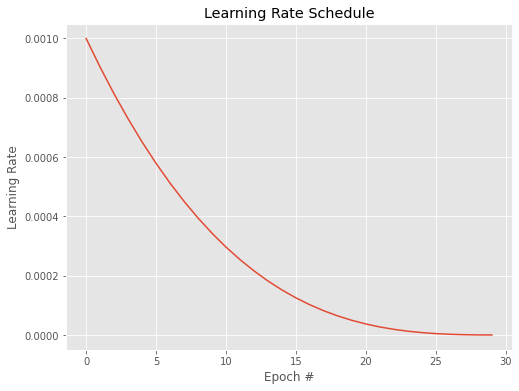

In [ ]:
N = np.arange(0, EPOCHS)

plt.rcParams["figure.figsize"] = 8 , 6
schedule.plot(N)

In [ ]:
# model.save("/models/cnn-model/cats-dogs-classifier.model")

###Model Evaluation

After training the model we have to evaluate it. In the first step we have to plot training accuracy and validation accuracy.

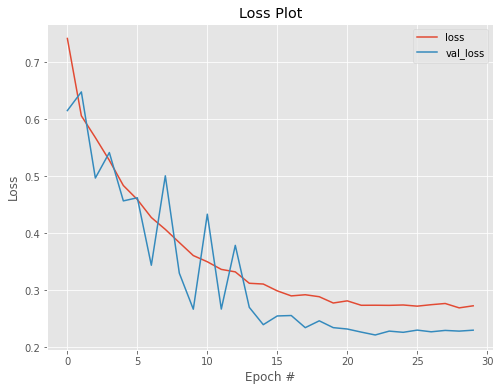

In [ ]:
fig , ax1 = plt.subplots(figsize = (8 , 6))
ax1.plot(r.history["loss"] , label = "loss")
ax1.plot(r.history["val_loss"] , label = "val_loss")
ax1.set_title("Loss Plot")  
ax1.set_xlabel("Epoch #")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

One of the important things we have to note that is that our validation loss is lower than our training loss which most at the times is not a problem. But this phenomenon happens by several reasons.

1. The regularization is only applied on the training set. With regularization(e.g. Data Augmetation) we somehow sacrifice the training data to get a better result for the test set performance.
2. The validation set may be easier than the training set.
3. Data Leakage (This phenomenon makes some serious problems in furthure developement)
4.  Training loss is measured during each epoch while validation loss is measured after each epoch. To solve this problem, we have to shift the training loss plot by 0.5 to the left.
\
[(Source)](https://www.pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss/)

In [ ]:
epochs = list(range(EPOCHS))
shifted_epoch = [x - 0.5 for x in epochs]

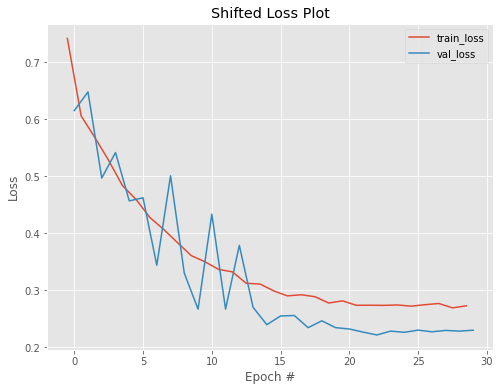

In [ ]:
fig , ax2 = plt.subplots(figsize = (8 , 6))
ax2.plot(shifted_epoch , r.history["loss"] , label = "train_loss")
ax2.plot(epochs, r.history["val_loss"] , label = "val_loss")
ax2.set_title("Shifted Loss Plot")  
ax2.set_xlabel("Epoch #")
ax2.set_ylabel("Loss")
ax2.grid(True)
ax2.legend()

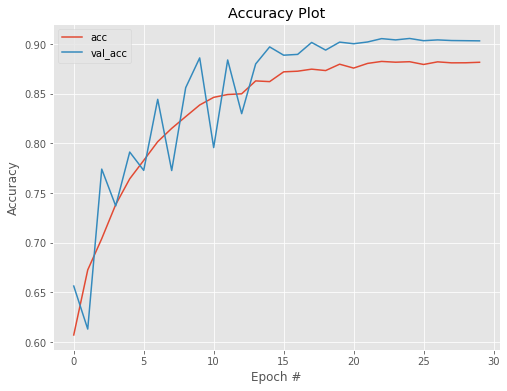

In [ ]:
fig , ax3 = plt.subplots(figsize = (8 , 6))
ax3.plot(r.history["accuracy"] , label = "acc")
ax3.plot(r.history["val_accuracy"] , label = "val_acc")
ax3.set_title("Accuracy Plot")  
ax3.set_xlabel("Epoch #")
ax3.set_ylabel("Accuracy")
ax3.grid(True)
ax3.legend()

In [ ]:
prediction = model.predict(X_test , batch_size = BS).argmax(axis = 1)

In [ ]:
prediction

array([1, 0, 0, ..., 0, 0, 1])

In [ ]:
print(classification_report(y_test.argmax(axis = 1) , prediction))

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      3115
           1       0.88      0.94      0.91      3115

    accuracy                           0.90      6230
   macro avg       0.91      0.90      0.90      6230
weighted avg       0.91      0.90      0.90      6230



In [ ]:
label_dict = {0 :"Cat" , 1 : "Dog"}

In [ ]:
import itertools
def plot_confusion_matrix(cm , classes , title = "Confusion Matrix" , figsize = (5 ,5) , cmap = plt.cm.Blues):
  
  print(cm)
  
  fig , ax = plt.subplots(figsize = figsize)
  im = ax.imshow(cm ,  interpolation = "nearest" , cmap = cmap)
  ax.set_title(title)
  fig.colorbar(im)
  tick_marks = np.arange(len(classes))
  ax.set_xticks(tick_marks)
  ax.set_yticks(tick_marks)

  thresh = cm.max() / 2
  for i , j in itertools.product(range(cm.shape[0]) , range(cm.shape[1])):
    plt.text(j , i , format(cm[i , j] , "d") , horizontalalignment = "center", 
              color = "white" if cm[i , j] > thresh else "black")
          
  plt.tight_layout()
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")
  ax.set_xticklabels(label_dict.values())
  ax.set_yticklabels(label_dict.values()) 
  plt.grid(False)
  plt.show()

In [ ]:
cm = confusion_matrix(y_test.argmax(axis = 1), prediction)

[[2697  418]
 [ 184 2931]]


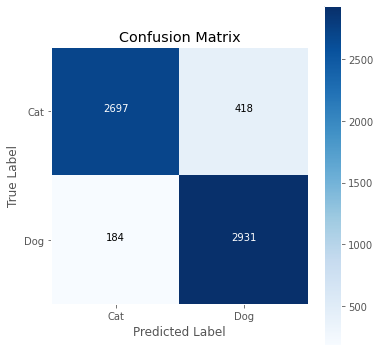

In [ ]:
plot_confusion_matrix(cm , classes = list(range(2)))

In [ ]:
y_train[0:5]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [ ]:
y_test[0:5]

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [ ]:
y_testFlattened = []
for i in range(len(y_test)):
  y_testFlattened.append(y_test[i][1]) 
y_testFlattened = np.array(y_testFlattened , dtype = "int")

In [ ]:
y_testFlattened[0:10]

array([1, 0, 1, 1, 0, 1, 0, 0, 1, 0])

In [ ]:
def plotClassified(X_test , predict , y_test , figsize = (15 , 15) , wspace = 0.1  , hspace = 0.3):
  plt.rcParams["axes.grid"] = True
  plt.rcParams["axes.edgecolor"] = "0.15"                 # selecting edge/border color for each image
  plt.rcParams["axes.linewidth"]  = 1.25                  # assining a edge/border width for each image

  fig , axes = plt.subplots(3 , 3 , figsize = figsize)
  plt.subplots_adjust(wspace = wspace , hspace = hspace)        # determining the width gap and height gap between each subplots

  axes = axes.flatten()                                   # for using axes indeces with one dimention array instead of two dimension

  for i in range(0 , 9):
    classified_idx = np.where(predict == y_test)[0]    # representing misclassified images
    n = np.random.choice(classified_idx)
    img = np.reshape(X_test[n], (100 , 100))                # converting a 1-D array into 2-D 224x224 array
    axes[i].imshow(img , cmap = "gray")
    axes[i].title.set_text("True label : {} , predicted : {}".format(label_dict[y_testFlattened[n]] , label_dict[predict[n]]))
    axes[i].tick_params(labelbottom = False , labelleft = False)    # removing labels/ticks along x axis and y axis
    axes[i].grid(False)

In [ ]:
def plotMisclassified(X_test , predict , y_test , figsize = (15 , 15) , wspace = 0.1  , hspace = 0.3):
  
  
  try:
    plt.rcParams["axes.grid"] = True
    plt.rcParams["axes.edgecolor"] = "0.15"                 # selecting edge/border color for each image
    plt.rcParams["axes.linewidth"]  = 1.25                  # assining a edge/border width for each image

    fig , axes = plt.subplots(3 , 3 , figsize = figsize)
    plt.subplots_adjust(wspace = wspace , hspace = hspace)        # determining the width gap and height gap between each subplots

    axes = axes.flatten()                                   # for using axes indeces with one dimention array instead of two dimension

    for i in range(0 , 9):
      classified_idx = np.where(predict != y_test)[0]    # representing misclassified images
      n = np.random.choice(classified_idx)
      img = np.reshape(X_test[n], (100 , 100))                # converting a 1-D array into 2-D 224x224 array
      axes[i].imshow(img, cmap = "gray")
      axes[i].title.set_text("True label : {} , predicted : {}".format(label_dict[y_testFlattened[n]] , label_dict[predict[n]]))
      axes[i].tick_params(labelbottom = False , labelleft = False)    # removing labels/ticks along x axis and y axis
      axes[i].grid(False)
  except:
    print("There is nothing to plot here...")  

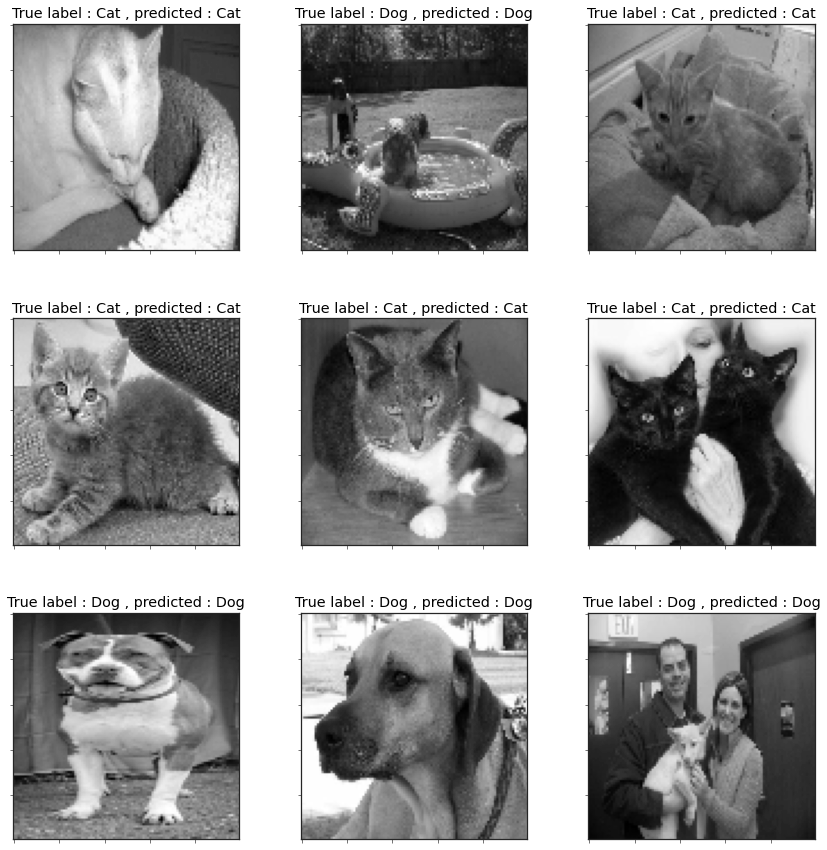

In [ ]:
plotClassified(X_test , prediction , y_testFlattened)

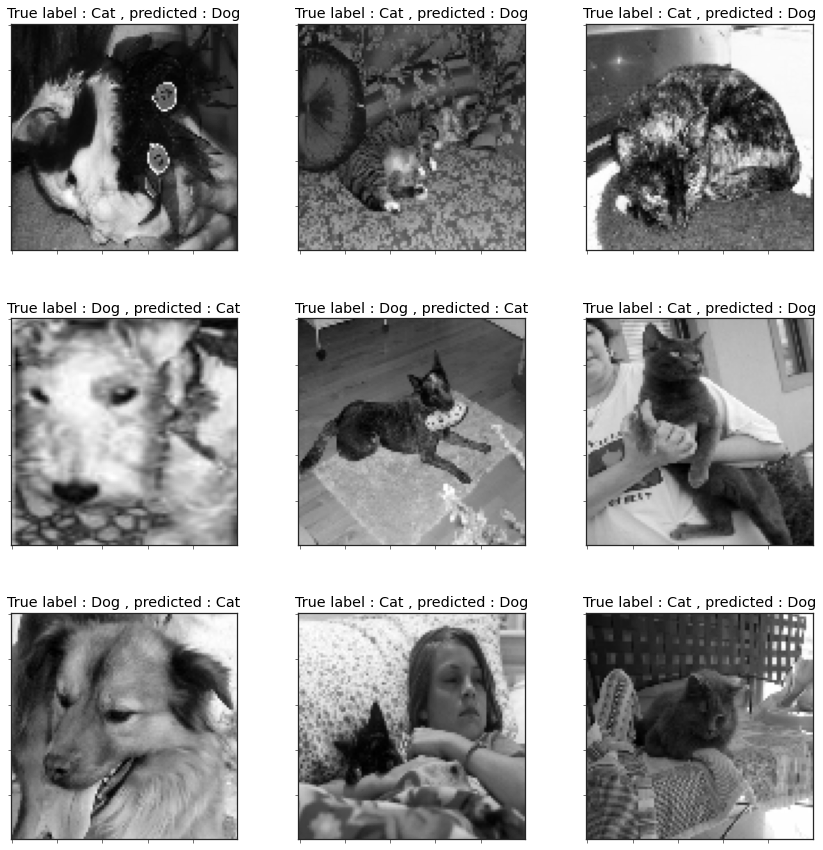

In [ ]:
plotMisclassified(X_test , prediction , y_testFlattened)